In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('../plotting.mplstyle')
import sys
sys.path.append("./../code/")
from piCurve import *
from matplotlib import cm
from gwBackground import *
from makeDelayedRateData import *
from scipy.special import gammainc
from geometry import *
import population_parameters

blue = "#1f78b4"
green = "#33a02c"
red = "#e31a1c"

In [2]:
def read_output(filepath):
    
    # Read hdf file
    hfile = h5py.File(filepath,'r')
    
    # Get joint 2D posteriors
    resultsDict = {k:v[()] for k,v in hfile['result'].items()}
    
    return resultsDict

def get_max_likelihood_params(resultDict):
    
    dc_argmax,z_argmax = np.unravel_index(np.argmax(resultDict['probabilities']),resultDict['probabilities'].shape)
    kappa_dc_max = resultDict['kappa_dcs_2D'][dc_argmax]
    kappa_z_max = resultDict['kappa_zs_2D'][z_argmax]
    
    return kappa_dc_max,kappa_z_max

In [3]:
# Input data
f_H1L1_O3,C_H1L1_O3,sigma_H1L1_O3 = np.loadtxt('../input/H1L1_O3.dat',unpack=True,skiprows=1)
f_H1V1_O3,C_H1V1_O3,sigma_H1V1_O3 = np.loadtxt('../input/H1V1_O3.dat',unpack=True,skiprows=1)
f_L1V1_O3,C_L1V1_O3,sigma_L1V1_O3 = np.loadtxt('../input/L1V1_O3.dat',unpack=True,skiprows=1)

# Inference results
HLO3 = read_output('./../data/fixed_rate_delayedSFR_HLO3.hdf')
HVO3 = read_output('./../data/fixed_rate_delayedSFR_HVO3.hdf')
LVO3 = read_output('./../data/fixed_rate_delayedSFR_LVO3.hdf')
full = read_output('./../data/fixed_rate_delayedSFR.hdf')

In [4]:
# Get max likelihood parameters for reference
HLO3_kappa_dc_max,HLO3_kappa_z_max = get_max_likelihood_params(HLO3)
HVO3_kappa_dc_max,HVO3_kappa_z_max = get_max_likelihood_params(HVO3)
full_kappa_dc_max,full_kappa_z_max = get_max_likelihood_params(full)

In [5]:
# First prepare a grid of redshifts and (arbitrarily normalized) merger rate values.
# In this case, our model a metallicity-weighted and time-delayed Madau+Dickinson SFR
rateData = generateTimeDelayData()
zs_merger = rateData['zs']
time_delays = rateData['tds']
zs_formation = rateData['formationRedshifts']
formationRates = rateData['formationRates']

# The following function is an approximation to the integrated fraction of star formation below
# Z=Z_sun/10 as a function of redshift
low_Z_fraction = gammainc(0.84,(0.1**2.)*np.power(10.,0.3*zs_formation))

# Multiply by total formation rate to get the rate of low metallicity star formation
weightedFormationRates = formationRates*low_Z_fraction

# Convolve formation rate with time-delay distribution
# Set t_min = 10 Myr
tdMin = 0.01
dpdt = np.power(time_delays,-1)
dpdt[time_delays<tdMin] = 0.
dRdV_delayed = weightedFormationRates.dot(dpdt)
dRdV_delayed /= dRdV_delayed[0]

# Instantiate SGWB calculator
m_absolute_min = 2.
m_absolute_max = 100.
omg = OmegaGW_BBH(m_absolute_min,m_absolute_max,zs_merger,gridSize=(30,29))

# Define hyperparameters describing mass distribution
R0 = population_parameters.R0
m_min = population_parameters.m_min
m_max = population_parameters.m_max
dm_min = population_parameters.dm_min
dm_max = population_parameters.dm_max
alpha = population_parameters.alpha_m
mu_peak = population_parameters.mu_peak
sig_peak = population_parameters.sig_peak
frac_peak = population_parameters.frac_peak
bq = population_parameters.bq

# Pass these to our SGWB calculator
omg.setProbs_plPeak(m_min,m_max,dm_min,dm_max,alpha,mu_peak,sig_peak,frac_peak,bq)

/Users/tcallister/Documents/Repositories/stochastic-birefringence/figures/./../code/gwBackground.py:352: RuntimeWarning: divide by zero encountered in divide
  probs_m2 = (1.+bq)*np.power(self.m2s_2d,bq)/(np.power(self.m1s_2d,1.+bq)-2.**(1.+bq))


In [6]:
# As noted elsewhere, to properly define the cumulative SNR we have to use identical ORFs
# to those used in the initial creation of the stochastic data.
# Hence we are loading in ORFs computed using stochastic.m
matlab_orf_freqs,matlab_orf_H1L1,matlab_orf_H1V1,matlab_orf_L1V1 = np.loadtxt('../input/matlab_orfs.dat',unpack=True)

# Also as noted elsewhere, the frequency arrays in publicly released stochastic data lack the
# required precision to fully specify the correct frequencies. Load frequencies as well
# from the raw matlab calculation
freqs = matlab_orf_freqs[matlab_orf_freqs<=1726]
matlab_orf_H1L1 = matlab_orf_H1L1[matlab_orf_freqs<=1726]
matlab_orf_H1V1 = matlab_orf_H1V1[matlab_orf_freqs<=1726]
matlab_orf_L1V1 = matlab_orf_L1V1[matlab_orf_freqs<=1726]

# Instantiate baseline objects
H1L1 = Baseline(Detector.H1(),Detector.L1())
H1V1 = Baseline(Detector.H1(),Detector.V1())
L1V1 = Baseline(Detector.L1(),Detector.V1())

# Use baseline objects to compute overlap reduction functions for Stokes-I and Stokes-V signals
H1L1_gammaI,H1L1_gammaV = H1L1.stokes_overlap_reduction_functions(freqs)
H1V1_gammaI,H1V1_gammaV = H1V1.stokes_overlap_reduction_functions(freqs)
L1V1_gammaI,L1V1_gammaV = L1V1.stokes_overlap_reduction_functions(freqs)

In [7]:
# Evaluate background
full_OmgI,full_OmgV = omg.eval(R0,dRdV_delayed,freqs,full_kappa_dc_max,full_kappa_z_max)

# Obtain signal models for each baseline
HL_model = np.array(full_OmgI + (H1L1_gammaV/matlab_orf_H1L1)*full_OmgV)
HV_model = np.array(full_OmgI + (H1V1_gammaV/matlab_orf_H1V1)*full_OmgV)
LV_model = np.array(full_OmgI + (L1V1_gammaV/matlab_orf_L1V1)*full_OmgV)

In [8]:
def get_cumulative_snr(Cs,sigmas,model):
    
    Cs[np.isinf(sigmas)] = 0
    signal_inner_model = np.cumsum(Cs*model/sigmas**2)
    model_inner_model = np.cumsum(model**2/sigmas**2)
    
    return signal_inner_model/np.sqrt(model_inner_model)

In [9]:
# Hanford-Livingston SNRs
cumulative_HL = get_cumulative_snr(C_H1L1_O3,sigma_H1L1_O3,HL_model)
optimal_HL = get_cumulative_snr(HL_model,sigma_H1L1_O3,HL_model)

# Hanford-Virgo SNRs
cumulative_HV = get_cumulative_snr(C_H1V1_O3,sigma_H1V1_O3,HV_model)
optimal_HV = get_cumulative_snr(HV_model,sigma_H1V1_O3,HV_model)

# Livingston-Virgo SNRs
cumulative_LV = get_cumulative_snr(C_L1V1_O3,sigma_L1V1_O3,LV_model)
optimal_LV = get_cumulative_snr(LV_model,sigma_L1V1_O3,LV_model)

/var/folders/b2/tcwq2bcs0214_0cxpktjl4t80000gn/T/ipykernel_57842/4118186826.py:7: RuntimeWarning: invalid value encountered in divide
  return signal_inner_model/np.sqrt(model_inner_model)


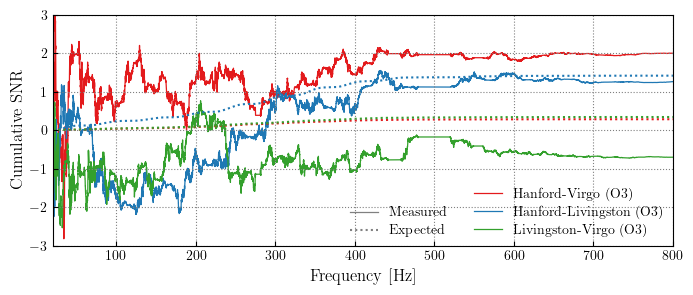

In [10]:
fig,ax = plt.subplots(figsize=(8,3))
ax.set_rasterization_zorder(2)

l2, = ax.plot(freqs,cumulative_HV,color=red,lw=0.9,alpha=1,label='Hanford-Virgo (O3)',zorder=0)
l1, = ax.plot(freqs,cumulative_HL,color=blue,lw=0.9,alpha=1,label='Hanford-Livingston (O3)',zorder=0)
ax.plot(freqs,cumulative_LV,color=green,lw=0.9,alpha=1,label='Livingston-Virgo (O3)',zorder=0)

l3, = ax.plot(freqs,optimal_HL,color=blue,dashes=(1,1.5),lw=1.5,zorder=1)
l4, = ax.plot(freqs,optimal_HV,color=red,dashes=(1,1.5),lw=1.5,zorder=1)
ax.plot(freqs,optimal_LV,color=green,dashes=(1,1.5),lw=1.5,zorder=1)

legend1 = plt.legend(loc=[0.67,0.01],fontsize=10,labelspacing=0.3)
legend2 = ax.legend([l1,l3],['Measured','Expected'],loc=[0.47,0.013],fontsize=10,labelspacing=0.35)
legend2.legendHandles[0].set_color('grey')
legend2.legendHandles[1].set_color('grey')
ax.add_artist(legend1)

ax.set_xlim(20,800)
ax.set_ylim(-3,3)
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Cumulative SNR')

plt.savefig('figure_12.pdf',bbox_inches='tight',dpi=200)

In [11]:
# Save our fitting results
with open('./SNR_macros.txt','w') as macrofile:
    
    macrofile.write("\\newcommand{{\\MaxLikelihoodKappaDC}}{{{0:.3f}}}".format(full_kappa_dc_max))
    macrofile.write("\n")
    
    macrofile.write("\\newcommand{{\\MaxLikelihoodKappaZ}}{{{0:.3f}}}".format(full_kappa_z_max))
    macrofile.write("\n")
    
    macrofile.write("\\newcommand{{\\HLSNR}}{{{0:.1f}}}".format(cumulative_HL[-1]))
    macrofile.write("\n")
    
    macrofile.write("\\newcommand{{\\HVSNR}}{{{0:.1f}}}".format(cumulative_HV[-1]))
    macrofile.write("\n")
    
    macrofile.write("\\newcommand{{\\LVSNR}}{{{0:.1f}}}".format(cumulative_LV[-1]))
    macrofile.write("\n")